In [19]:
import warnings
warnings.filterwarnings("ignore") # Suppress warnings, useful for cleaner output

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, f1_score

In [2]:
# Simulate stock price data with trading volume and potential anomalies
np.random.seed(123)

dates = pd.date_range('2023-01-01', periods=200, freq='D')  # Simulate for 200 days

# Simulate stock prices with some random fluctuations
price_data = np.cumsum(np.random.randn(200) * 2 + 0.1)  # Simulating a random walk

# Inject anomalies in price data
anomaly_indices_price = np.random.choice(range(200), 6, replace=False)  # Randomly select 6 anomalies
for idx in anomaly_indices_price:
    price_data[idx] += np.random.choice([20, -30, 50, -40])  # Varying anomalies: price jump, drop, etc.

# Simulate trading volume (normal volume with occasional anomalies)
volume_data = np.random.poisson(1000, 200)  # Normally distributed volume data

# Inject anomalies in volume data
anomaly_indices_volume = np.random.choice(range(200), 5, replace=False)  # Randomly select 5 anomalies
for idx in anomaly_indices_volume:
    volume_data[idx] += np.random.choice([10000, -8000, 5000])  # Varying anomalies: volume spike, drop, etc.

# Create DataFrame with stock price and volume data
data = pd.DataFrame({'date': dates, 'price': price_data, 'volume': volume_data})
data.set_index('date', inplace=True)

# Create 'true_anomaly' column based on specified price and volume anomalies
data['true_anomaly_price'] = 0  # Default value: 0 (no anomaly)
data['true_anomaly_volume'] = 0  # Default value: 0 (no anomaly)


# Set true_anomaly to 1 for the specified anomaly indices
data.iloc[anomaly_indices_price, data.columns.get_loc('true_anomaly_price')] = 1
data.iloc[anomaly_indices_volume, data.columns.get_loc('true_anomaly_volume')] = 1

data.head()

,price,volume,true_anomaly_price,true_anomaly_volume
date,,,,
2023-01-01,-2.071261,974,0,0
2023-01-02,0.023430,1075,0,0
2023-01-03,0.689387,1027,0,0
2023-01-04,-2.223203,970,0,0
2023-01-05,-3.280403,1031,0,0


In [3]:
data['true_anomaly_price'] = data['true_anomaly_price'].map({0: False, 1: True})
data['true_anomaly_volume'] = data['true_anomaly_volume'].map({0: False, 1: True})

anomalies_price = data[data['true_anomaly_price'] == True]
anomalies_volume = data[data['true_anomaly_volume'] == True]

print('anomalies in price')
display(anomalies_price)

print('anomalies in volume')
display(anomalies_volume)

anomalies in price


,price,volume,true_anomaly_price,true_anomaly_volume
date,,,,
2023-01-12,14.262488,983,True,False
2023-03-09,-19.933859,1016,True,False
2023-04-09,-13.919832,1094,True,False
2023-04-18,-23.174535,1017,True,False
2023-04-29,-10.175682,1008,True,False
2023-07-05,80.600538,1054,True,False


anomalies in volume


,price,volume,true_anomaly_price,true_anomaly_volume
date,,,,
2023-02-19,6.327144,6054,False,True
2023-02-24,4.112062,5982,False,True
2023-03-05,15.592274,11002,False,True
2023-03-14,20.167564,5966,False,True
2023-07-14,29.355517,6032,False,True


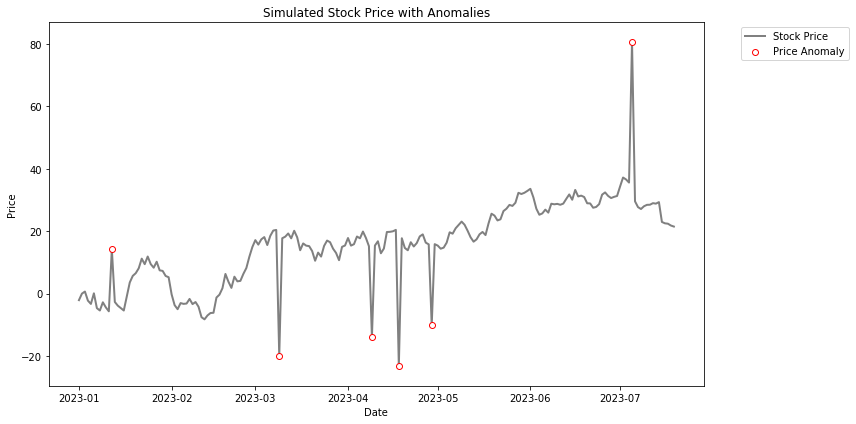

In [16]:
# Plot the simulated stock price with anomaly markers
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['price'], label='Stock Price', color='gray', lw=2)
plt.scatter(data.index[anomaly_indices_price], data['price'][anomaly_indices_price], color='white', label='Price Anomaly', zorder=5, edgecolors='red')

# for idx in anomaly_indices_price:
#    plt.scatter(data.index[idx], data['price'][idx], color='white', label='Price Anomaly', zorder=5, edgecolors='red')

plt.title('Simulated Stock Price with Anomalies')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout() 
plt.show()

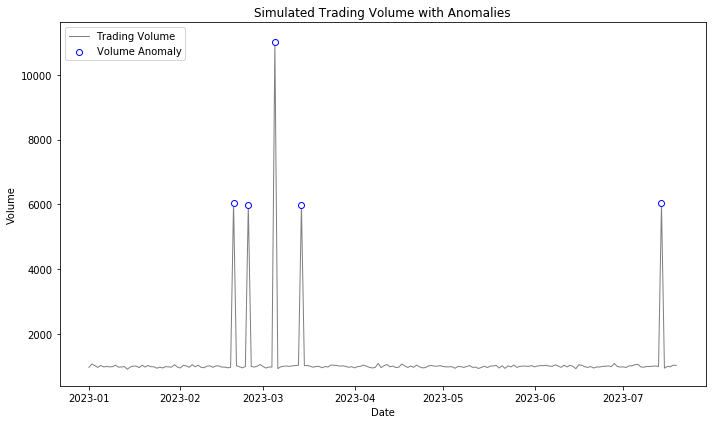

In [17]:
# Plot trading volume with anomaly markers
plt.figure(figsize=(10, 6))
plt.plot(data.index, data['volume'], label='Trading Volume', color='grey', lw=1)
# Plot anomalies in volume 
#for idx in anomaly_indices_volume:
#    plt.scatter(data.index[idx], data['volume'][idx], color='white', label='Volume Anomaly', zorder=5, edgecolors='blue')

plt.scatter(data.index[anomaly_indices_volume], data['volume'][anomaly_indices_volume], color='white', \
            label='Volume Anomaly', zorder=5, edgecolors='blue')

plt.title('Simulated Trading Volume with Anomalies')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend(loc='upper left')
plt.tight_layout()
plt.show()

If price and volume are expected to interact in a meaningful way, such as a price spike being relevant only when there's a corresponding volume spike, it's better to use Isolation Forest together on both features (price and volume).

If you're interested in price and volume anomalies independently, or if you want to treat them as separate features with different criteria (e.g., different contamination rates or thresholds for anomalies), apply Isolation Forest separately for price and volume.

In [6]:
# Anomaly Detection with Isolation Forest (for Price and Volume)

# Preprocess data: Standardize price and volume data separately
scaler = StandardScaler()

# Standardize price and volume separately
data['price_scaled'] = scaler.fit_transform(data[['price']])
data['volume_scaled'] = scaler.fit_transform(data[['volume']])

# Create a single Isolation Forest model
model = IsolationForest(
    n_estimators=100,          # Number of trees in the forest
    contamination=0.03,        # Contamination factor (expected percentage of anomalies)
    max_samples=256,           # Number of samples to train each tree on (use a fraction if dataset is large)
    random_state=123,          # Ensure reproducibility
    max_features=1.0,          # Use all features 
    bootstrap=False,           # Use bootstrapping (False for faster training)
    n_jobs=-1,                 # Use all cores for parallel computation
    warm_start=False           # Option to add data incrementally (can be set True for large datasets)
)

# Apply Isolation Forest model for price anomaly detection
price_anomalies = model.fit_predict(data[['price_scaled']])
data['price_anomaly'] = price_anomalies
data['price_anomaly'] = data['price_anomaly'].map({1: False, -1: True})

# Apply Isolation Forest model for volume anomaly detection
volume_anomalies = model.fit_predict(data[['volume_scaled']])
data['volume_anomaly'] = volume_anomalies
data['volume_anomaly'] = data['volume_anomaly'].map({1: False, -1: True})

# Show the data with anomalies detected
display(data.head())

,price,volume,true_anomaly_price,true_anomaly_volume,price_scaled,volume_scaled,price_anomaly,volume_anomaly
date,,,,,,,,
2023-01-01,-2.071261,974,False,False,-1.343100,-0.177884,False,False
2023-01-02,0.023430,1075,False,False,-1.184834,-0.075875,False,False
2023-01-03,0.689387,1027,False,False,-1.134518,-0.124355,False,False
2023-01-04,-2.223203,970,False,False,-1.354580,-0.181924,False,False
2023-01-05,-3.280403,1031,False,False,-1.434457,-0.120315,False,False


In [7]:
# Compare where the predicted anomaly in price does not match the true anomaly
price_comparison = data[data['true_anomaly_price'] != data['price_anomaly']]

# Compare where the predicted anomaly in volume does not match the true anomaly
volume_comparison = data[data['true_anomaly_volume'] != data['volume_anomaly']]

# Display the mismatches in both price and volume anomalies
display(price_comparison[['price', 'price_anomaly', 'true_anomaly_price']])
display(volume_comparison[['volume', 'volume_anomaly', 'true_anomaly_volume']])

,price,price_anomaly,true_anomaly_price
date,,,
2023-01-12,14.262488,False,True
2023-07-02,37.229804,True,False


,volume,volume_anomaly,true_anomaly_volume
date,,,
2023-01-14,913,True,False


In [8]:
# Confusion matrix and F1 score for price anomalies
price_cm = confusion_matrix(data['true_anomaly_price'], data['price_anomaly'])
price_f1 = f1_score(data['true_anomaly_price'], data['price_anomaly'])

# Confusion matrix and F1 score for volume anomalies
volume_cm = confusion_matrix(data['true_anomaly_volume'], data['volume_anomaly'])
volume_f1 = f1_score(data['true_anomaly_volume'], data['volume_anomaly'])

# Display confusion matrices and F1 scores
print("Confusion Matrix for Price Anomalies:")
print(price_cm)
print("F1 Score for Price Anomalies: {:.4f}".format(price_f1))

print("\nConfusion Matrix for Volume Anomalies:")
print(volume_cm)
print("F1 Score for Volume Anomalies: {:.4f}".format(volume_f1))

Confusion Matrix for Price Anomalies:
[[193   1]
 [  1   5]]
F1 Score for Price Anomalies: 0.8333

Confusion Matrix for Volume Anomalies:
[[194   1]
 [  0   5]]
F1 Score for Volume Anomalies: 0.9091


In [20]:
print("Model Evaluation Report for Price Anomalies:")
print(classification_report(data['true_anomaly_price'], data['price_anomaly']))

Model Evaluation Report for Price Anomalies:
              precision    recall  f1-score   support

       False       0.99      0.99      0.99       194
        True       0.83      0.83      0.83         6

    accuracy                           0.99       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.99      0.99      0.99       200



In [21]:
print("Model Evaluation Report for Volume Anomalies:")
print(classification_report(data['true_anomaly_volume'], data['volume_anomaly']))

Model Evaluation Report for Volume Anomalies:
              precision    recall  f1-score   support

       False       1.00      0.99      1.00       195
        True       0.83      1.00      0.91         5

    accuracy                           0.99       200
   macro avg       0.92      1.00      0.95       200
weighted avg       1.00      0.99      1.00       200



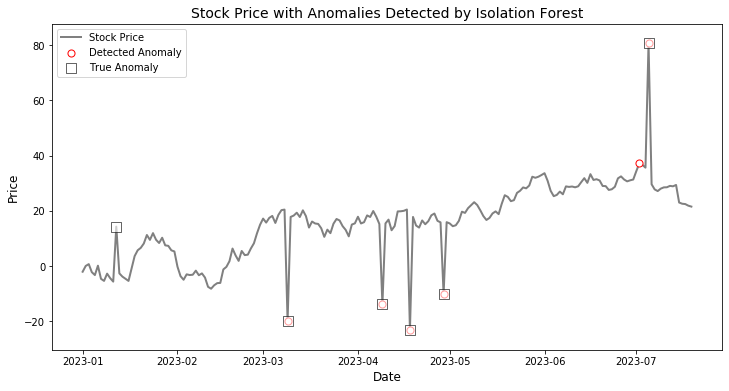

In [9]:
# Plot time series with detected anomalies and true anomalies for price

# Filter detected anomalies and true anomalies for price
detected_anomalies = data[data['price_anomaly'] == True]
true_anomalies = data[data['true_anomaly_price'] == True]

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['price'], label='Stock Price', color='gray', lw=2)
plt.scatter(detected_anomalies.index, detected_anomalies['price'], color='white', label='Detected Anomaly', 
            zorder=5, s=50, edgecolors='red')
plt.scatter(true_anomalies.index, true_anomalies['price'], color='white', label='True Anomaly', zorder=5, s=100,
            edgecolors='black', marker='s', alpha=0.6)

plt.title('Stock Price with Anomalies Detected by Isolation Forest', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=0)  
plt.show()

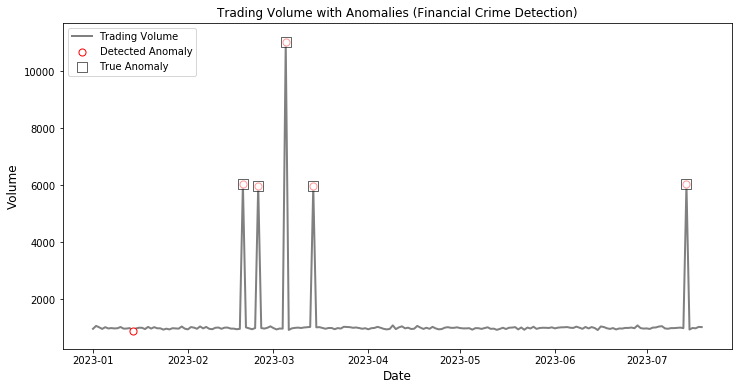

In [10]:
# Plot Trading Volume with anomalies

detected_anomalies = data[data['volume_anomaly'] == True]
true_anomalies = data[data['true_anomaly_volume'] == True]

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['volume'], label='Trading Volume', color='gray', lw=2)

plt.scatter(detected_anomalies.index, detected_anomalies['volume'], color='white', label='Detected Anomaly', 
            zorder=5, s=50, edgecolors='red')
plt.scatter(true_anomalies.index, true_anomalies['volume'], color='white', label='True Anomaly', zorder=5, s=100,
            edgecolors='black', marker='s', alpha=0.6)

# Set the title and labels
plt.title('Trading Volume with Anomalies (Financial Crime Detection)')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

In [11]:
# Anomaly Detection with Local Outlier Factor (for Price and Volume)

# Standardize price and volume separately
# scaler = StandardScaler()
# data['price_scaled'] = scaler.fit_transform(data[['price']])
# data['volume_scaled'] = scaler.fit_transform(data[['volume']])

# Define LOF model with the specified parameters
lof_model = LocalOutlierFactor(
    n_neighbors=20,           # Number of neighbors to consider (higher for larger datasets)
    contamination=0.03,       # Proportion of expected outliers (tune this value)
    metric='euclidean',       # Distance metric: 'euclidean', 'manhattan', or others (can tune based on data)
    p=2,                      # Power parameter for the Minkowski distance (use 2 for Euclidean, 1 for Manhattan)
    algorithm='auto',         # Algorithm to compute nearest neighbors: 'auto', 'ball_tree', 'kd_tree', 'brute'
    leaf_size=30,             # Leaf size for tree-based algorithms ('ball_tree', 'kd_tree')
    n_jobs=-1                 # Use all available CPU cores for parallel computation
)

# Apply LOF for price anomaly detection
price_lof_anomalies = lof_model.fit_predict(data[['price_scaled']])
data['price_lof_anomaly'] = price_lof_anomalies == -1  # LOF labels anomalies as -1

# Apply LOF for volume anomaly detection
volume_lof_anomalies = lof_model.fit_predict(data[['volume_scaled']])
data['volume_lof_anomaly'] = volume_lof_anomalies == -1  # LOF labels anomalies as -1

# Display the rows where LOF detected anomalies in price
display(data[data['price_lof_anomaly'] == True])

# Display the rows where LOF detected anomalies in volume
display(data[data['volume_lof_anomaly'] == True])

,price,volume,true_anomaly_price,true_anomaly_volume,price_scaled,volume_scaled,price_anomaly,volume_anomaly,price_lof_anomaly,volume_lof_anomaly
date,,,,,,,,,,
2023-03-09,-19.933859,1016,True,False,-2.692718,-0.135465,True,False,True,False
2023-04-09,-13.919832,1094,True,False,-2.238325,-0.056686,True,False,True,True
2023-04-18,-23.174535,1017,True,False,-2.937569,-0.134455,True,False,True,False
2023-04-29,-10.175682,1008,True,False,-1.955434,-0.143545,True,False,True,False
2023-07-02,37.229804,969,False,False,1.626313,-0.182934,True,False,True,False
2023-07-05,80.600538,1054,True,False,4.903212,-0.097085,True,False,True,False


,price,volume,true_anomaly_price,true_anomaly_volume,price_scaled,volume_scaled,price_anomaly,volume_anomaly,price_lof_anomaly,volume_lof_anomaly
date,,,,,,,,,,
2023-02-19,6.327144,6054,False,True,-0.708554,4.952862,False,True,False,True
2023-02-24,4.112062,5982,False,True,-0.875916,4.880142,False,True,False,True
2023-03-05,15.592274,11002,False,True,-0.008522,9.950289,False,True,False,True
2023-03-14,20.167564,5966,False,True,0.337166,4.863983,False,True,False,True
2023-04-09,-13.919832,1094,True,False,-2.238325,-0.056686,True,False,True,True
2023-07-14,29.355517,6032,False,True,1.031367,4.930642,False,True,False,True


In [12]:
# Compare where the LOF predicted anomaly in price does not match the true anomaly
price_comparison_lof = data[data['true_anomaly_price'] != data['price_lof_anomaly']]

# Compare where the LOF predicted anomaly in volume does not match the true anomaly
volume_comparison_lof = data[data['true_anomaly_volume'] != data['volume_lof_anomaly']]

# Display the mismatches in price anomalies
print("Mismatches in Price Anomalies (LOF vs True Anomalies):")
display(price_comparison_lof[['price', 'price_lof_anomaly', 'true_anomaly_price']])

# Display the mismatches in volume anomalies
print("Mismatches in Volume Anomalies (LOF vs True Anomalies):")
display(volume_comparison_lof[['volume', 'volume_lof_anomaly', 'true_anomaly_volume']])

Mismatches in Price Anomalies (LOF vs True Anomalies):


,price,price_lof_anomaly,true_anomaly_price
date,,,
2023-01-12,14.262488,False,True
2023-07-02,37.229804,True,False


Mismatches in Volume Anomalies (LOF vs True Anomalies):


,volume,volume_lof_anomaly,true_anomaly_volume
date,,,
2023-04-09,1094,True,False


In [13]:
from sklearn.metrics import confusion_matrix, f1_score

# Confusion matrix and F1 score for price anomalies (LOF)
price_cm_lof = confusion_matrix(data['true_anomaly_price'], data['price_lof_anomaly'])
price_f1_lof = f1_score(data['true_anomaly_price'], data['price_lof_anomaly'])

# Confusion matrix and F1 score for volume anomalies (LOF)
volume_cm_lof = confusion_matrix(data['true_anomaly_volume'], data['volume_lof_anomaly'])
volume_f1_lof = f1_score(data['true_anomaly_volume'], data['volume_lof_anomaly'])

# Display confusion matrices and F1 scores
print("Confusion Matrix for Price Anomalies (LOF):")
print(price_cm_lof)
print("F1 Score for Price Anomalies (LOF): {:.4f}".format(price_f1_lof))

print("\nConfusion Matrix for Volume Anomalies (LOF):")
print(volume_cm_lof)
print("F1 Score for Volume Anomalies (LOF): {:.4f}".format(volume_f1_lof))


Confusion Matrix for Price Anomalies (LOF):
[[193   1]
 [  1   5]]
F1 Score for Price Anomalies (LOF): 0.8333

Confusion Matrix for Volume Anomalies (LOF):
[[194   1]
 [  0   5]]
F1 Score for Volume Anomalies (LOF): 0.9091


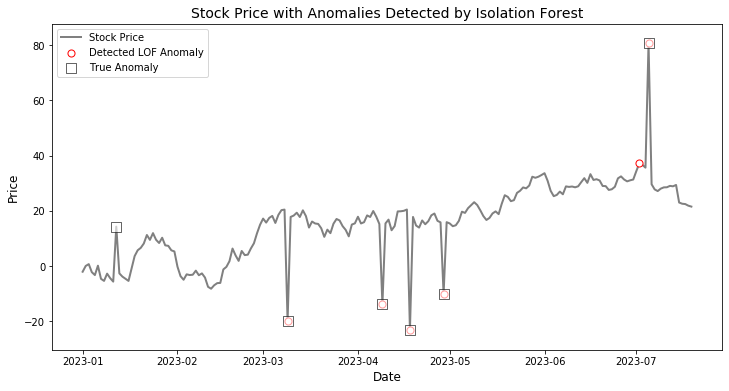

In [14]:
# Plot time series with detected anomalies and true anomalies for price

# Filter detected anomalies and true anomalies for price
detected_anomalies = data[data['price_lof_anomaly'] == True]
true_anomalies = data[data['true_anomaly_price'] == True]

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['price'], label='Stock Price', color='gray', lw=2)
plt.scatter(detected_anomalies.index, detected_anomalies['price'], color='white', label='Detected LOF Anomaly', 
            zorder=5, s=50, edgecolors='red')
plt.scatter(true_anomalies.index, true_anomalies['price'], color='white', label='True Anomaly', zorder=5, s=100,
            edgecolors='black', marker='s', alpha=0.6)

plt.title('Stock Price with Anomalies Detected by Isolation Forest', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=0)  
plt.show()

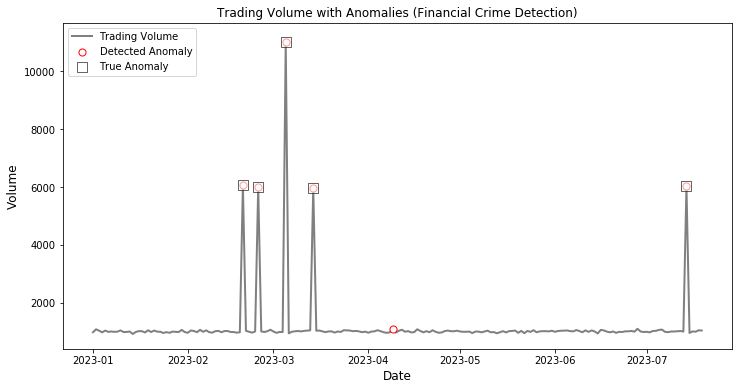

In [15]:
# Plot Trading Volume with anomalies

detected_anomalies = data[data['volume_lof_anomaly'] == True]
true_anomalies = data[data['true_anomaly_volume'] == True]

plt.figure(figsize=(12, 6))
plt.plot(data.index, data['volume'], label='Trading Volume', color='gray', lw=2)
plt.scatter(detected_anomalies.index, detected_anomalies['volume'], color='white', label='Detected Anomaly', 
            zorder=5, s=50, edgecolors='red')
plt.scatter(true_anomalies.index, true_anomalies['volume'], color='white', label='True Anomaly', zorder=5, s=100,
            edgecolors='black', marker='s', alpha=0.6)
plt.title('Trading Volume with Anomalies (Financial Crime Detection)')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Volume', fontsize=12)
plt.legend(loc='upper left')
plt.xticks(rotation=0) 
plt.show()